C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. P

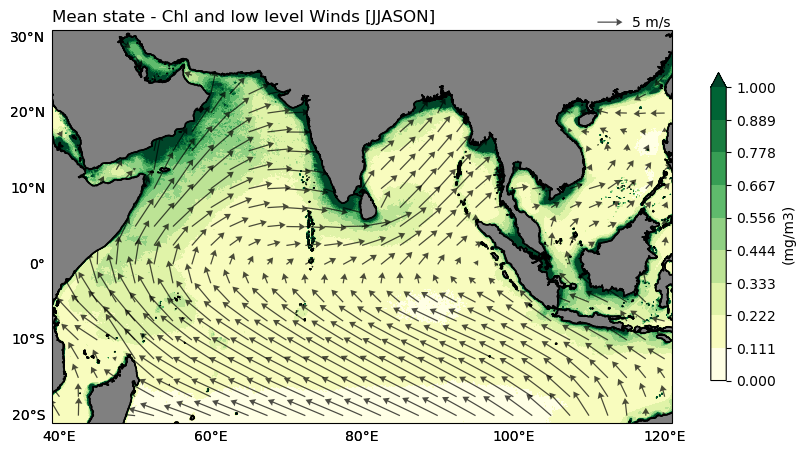

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load chlorophyll-a data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds_chl = xr.open_dataset(fn1)
ds_chl = ds_chl.sel(time=slice('1997-09','2023-07'))

chl = ds_chl.chlor_a
chl = chl.sel(lat=slice(31,-21))
chl = chl.sel(lon=slice(39,121))

jjason_chl = chl.sel(time=np.in1d(ds_chl['time.month'], [6,7,8,9,10,11]))
clm_chl = jjason_chl.groupby('time.month').mean('time')
average_chl = clm_chl[:,:,:].mean('month')

# Load wind data
fn2 = './surface_winds_ERA5.nc'
ds_wind = xr.open_dataset(fn2)
ds_wind = ds_wind.sel(time=slice('1997-09','2023-07'))

ds_wind = ds_wind.sel(latitude=slice(30,-20))
ds_wind = ds_wind.sel(longitude=slice(40,120))
ds_wind = ds_wind.rename({'latitude': 'lat', 'longitude': 'lon'})
ds_wind = ds_wind.isel(expver=0)
ds_wind = ds_wind.drop_vars('expver')

u = ds_wind.u10
v = ds_wind.v10

u_jjason = u.sel(time=np.in1d(u['time.month'], [6,7,8,9,10,11]))
u_clm = u_jjason.groupby('time.month').mean('time')
u_average_chl = u_clm.mean('month')

v_jjason = v.sel(time=np.in1d(v['time.month'], [6,7,8,9,10,11]))
v_clm = v_jjason.groupby('time.month').mean('time')
v_average_chl = v_clm.mean('month')

# Function to plot wind vectors
def uv_plot(ax, ur, vr):
    x, y = np.meshgrid(ur.lon, ur.lat)
    U = ur
    V = vr
    i = 10
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='k', alpha=0.7, headwidth=6, scale=20, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.NaturalEarthFeature(
        category='physical', name='land', facecolor='gray', edgecolor='black', scale='10m'
    ))
    ax.coastlines(resolution='10m', linewidth=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MultipleLocator(base=20)
    gl.ylocator = mticker.MultipleLocator(base=10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.quiverkey(q, X=0.92, Y=1.02, U=5, label='5 m/s', labelpos='E')
    ax.set_title('Wind Climatology [JJASON]', loc='left')

# Create combined plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot chlorophyll-a data
contour = average_chl.plot.contourf(ax=ax, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor=cfeature.COLORS['land']
)
ax.add_feature(land, edgecolor='black', facecolor='gray')
ax.coastlines(resolution='10m', linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.MultipleLocator(base=20)
gl.ylocator = mticker.MultipleLocator(base=10)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Overlay wind vectors
uv_plot(ax, u_average_chl, v_average_chl)

# Set the title of the plot and align it to the left
plt.title('Mean state - Chl and low level Winds [JJASON]', loc='left')

# Show the plot
plt.show()
